In [1]:
from luprox import linear_uncertainty, mc_uncertainty, monte_carlo

In [2]:
from matplotlib import pyplot as plt
from jax import numpy as jnp
from jax import random, vmap, jit, lax
import jax
from functools import partial

In [3]:
# Test function
def f(x):
    return (1/(1+jnp.abs(0.3*x)**2))

# Settings
test_point = jnp.array([2.])
cov_x = jnp.array([[0.05]]) # Covariance matrix for x (scalar for 1D random variables)
x_vec = jnp.linspace(-10,10,1000)
x_array = jnp.expand_dims(x_vec, axis=1)

# Random seed
key = random.PRNGKey(42)

In [4]:
# Add linear uncertainty estimation to f
f_up_approx = linear_uncertainty(f)

# Add Monte Carlo uncertainty estimation to f
f_up_mc = mc_uncertainty(f, trials=1000)

In [5]:
# Test on a single sample
mu_linear, cov_linear = f_up_approx(test_point, cov_x)
mu_mc, cov_mc = f_up_mc(test_point, cov_x, key)

print("STD: {} (Linear) | {} (Monte Carlo)".format(
    jnp.sqrt(cov_linear[0,0]), 
    jnp.sqrt(cov_mc)
))

STD: 0.04352208226919174 (Linear) | 0.04308144003152847 (Monte Carlo)


In [6]:
# Composing with jax transformation
f_hat = vmap(f_up_approx, in_axes=(0,None))
f_mc =  vmap(f_up_mc,     in_axes=(0,None, None))

In [7]:
y_linear, cov_y_mat = f_hat(x_array, cov_x)
ci_linear = jnp.sqrt(cov_y_mat[:,0,0])*3 # 3 sigma
y_linear = y_linear[:,0]

In [8]:
y_mc, cov_y_mat = f_mc(x_array, cov_x, key)
ci_mc = jnp.sqrt(cov_y_mat)*3 # 3 sigma
y_mc = y_mc[:,0]

Text(0.5, 1.0, 'Monte Carlo (N=1000)')

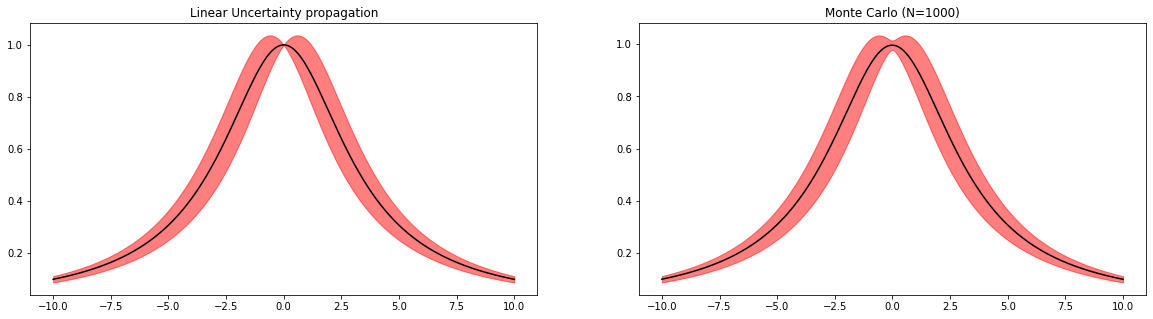

In [9]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(x_vec, y_linear, color="black")
ax[0].fill_between(x_vec, y_linear-ci_linear, y_linear+ci_linear, color="red", alpha=0.5)
ax[0].set_title("Linear Uncertainty propagation")

ax[1].plot(x_vec, y_mc, color="black")
ax[1].fill_between(x_vec, y_mc-ci_mc, y_mc+ci_mc, color="red", alpha=0.5)
ax[1].set_title("Monte Carlo (N=1000)")

In [10]:
%%timeit 
f_hat(x_array+0.2, cov_x)[1].block_until_ready()

369 µs ± 7.02 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%%timeit 
f_mc(x_array+0.2, cov_x, key)[1].block_until_ready()

2.76 ms ± 34.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# ODE integration

Example adapted from [Chris Rackauckas notes on uncertainty programming](https://mitmath.github.io/18337/lecture19/uncertainty_programming)

In [12]:
# from https://github.com/astanziola/jwave/blob/main/jwave/ode.py

def euler_integration(f, x0, dt, output_steps):
    assert any(map(lambda x: x >= 0, output_steps))
    return _euler_integration(f, x0, dt, output_steps)


@partial(jit, static_argnums=(0,))
def _euler_integration(f, x0, dt, output_steps):

    def euler_step(i, x):
        dx_dt = f(x, i * dt)
        return jax.tree_util.tree_multimap(
            lambda x, y: jnp.add(x, y * dt), x, dx_dt
        )

    def euler_jump(x_t, i):
        x = x_t[0]
        start = x_t[1]
        end = start + i

        y = jax.lax.fori_loop(start, end, euler_step, x)
        return (y, end), y

    jumps = jnp.diff(output_steps)

    _, ys = lax.scan(euler_jump, (x0, 0.0), jumps)
    return jnp.concatenate([jnp.expand_dims(x0,0),ys])

In [13]:
t_max = 6.3
dt = 0.01
t = jnp.arange(0., t_max, dt)

params = jnp.array([9.81, 1., .0, jnp.pi/3, 0.])
cov_in = jnp.diag(jnp.array([0.0001, 0.001, 0.001, 0.002, 0.0001]))

@jit
def solve_pendulum(params):
    g = params[0]
    L = params[1]
    alpha = params[2]
    u0 = params[3:]
    
    def damped_pendulum(u, t):
        theta = u[0]
        vel = u[1]
        d_theta = u[1]
        d_vel = - (g/L)*jnp.sin(u[0]) - alpha*u[1]
        return jnp.stack([d_theta, d_vel])
    
    trajectory = euler_integration(damped_pendulum, u0, dt, t)
    return trajectory[:,0]

In [14]:
solve_linear = linear_uncertainty(solve_pendulum)
solve_mc = mc_uncertainty(f, trials=1000)
sampler = monte_carlo(solve_pendulum, trials=40)

In [15]:
linear_trajectory, covariance = solve_linear(params, cov_in)
sigma_3 = jnp.sqrt(jnp.diag(covariance))*2

mc_trajectory, mc_cov = solve_mc(params, cov_in, key)

samples = sampler(params, cov_in, key)

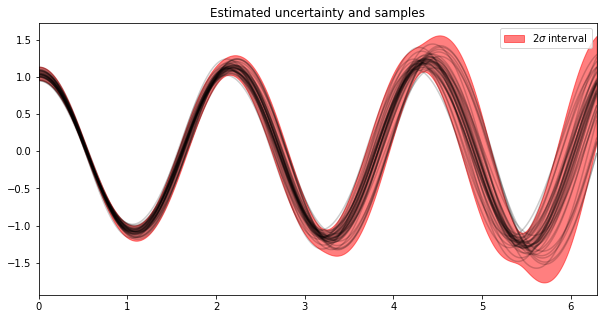

In [16]:
plt.figure(figsize=(10,5))
plt.fill_between(
    t, 
    linear_trajectory-sigma_3, 
    linear_trajectory+sigma_3, 
    color="red", 
    alpha=0.5, 
    label="2$\sigma$ interval"
)
plt.xlim([t[0], t[-1]])
plt.plot(t, samples.T, color="black", alpha=0.2)
plt.title("Estimated uncertainty and samples")
plt.legend()
plt.show()

Remember that this estimate is biased, as it relies on a first order linear expansion of the function. This is visible when the parameter uncertainty is large

In [17]:
cov_in_large = jnp.diag(jnp.array([0.01, 0.01, 0.01, 0.02, 0.01]))

In [18]:
linear_trajectory, covariance = solve_linear(params, cov_in_large)
sigma_3 = jnp.sqrt(jnp.diag(covariance))

samples = sampler(params, cov_in_large, key)

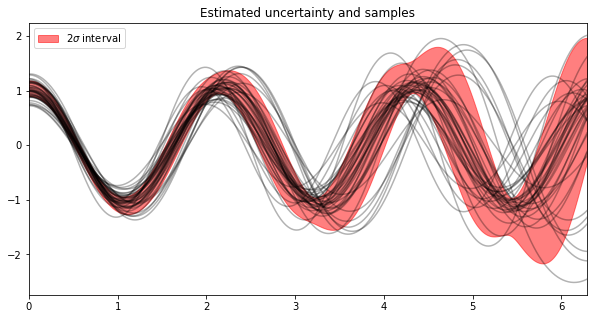

In [26]:
plt.figure(figsize=(10,5))
plt.fill_between(
    t, 
    linear_trajectory-sigma_3, 
    linear_trajectory+sigma_3, 
    color="red", 
    alpha=0.5, 
    label="2$\sigma$ interval"
)
plt.xlim([t[0], t[-1]])
plt.plot(t, samples.T, color="black", alpha=0.3)
plt.title("Estimated uncertainty and samples")
plt.legend()
plt.show()

or for long simulation times (i.e. highly non linear functions)

# Execution times

In [27]:
%%timeit
solve_pendulum(params).block_until_ready()

80.8 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [28]:
%%timeit
solve_linear(params, cov_in)[1].block_until_ready()

161 µs ± 2.41 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [29]:
%%timeit
solve_mc(params, cov_in, key)[1].block_until_ready()

221 µs ± 4.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
